In [12]:
# import config
import torch
import numpy as np
from autoencoder import ConvDecoder, ConvEncoder
from sklearn.neighbors import NearestNeighbors
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
# from lshash import LSHash
from lshash.lshash import LSHash
%matplotlib inline

In [13]:
TEST_IMAGE_PATH = "/Users/abhishekvaidyanathan/Downloads/geological_similarity/schist/ZZ5Z5.jpg"
NUM_IMAGES = 10
ENCODER_MODEL_PATH = "geological_encoding.pt"
EMBEDDING_PATH = "geological_embed.npy"

In [21]:
rootdir = '/Users/abhishekvaidyanathan/Downloads/geological_similarity/'
image_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        image_files.append(os.path.join(subdir, file))

In [15]:
def load_image_tensor(image_path, device):
    image_tensor = T.ToTensor()(Image.open(image_path))
    image_tensor = image_tensor.unsqueeze(0)
    print(image_tensor.shape)
    # input_images = image_tensor.to(device)
    return image_tensor

In [33]:
def compute_similar_images(image_path, num_images, embedding, device):
    image_tensor = load_image_tensor(image_path, device)
    # image_tensor = image_tensor.to(device)

    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()

    print(image_embedding.shape)

    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
    print("flattened embedding")
    print(flattened_embedding.shape)

    k = 1 # hash size
    L = 5  # number of tables
    d = flattened_embedding.shape[1] # Dimension of Feature vector
    lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)
    # LSH on all the images
    # for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(flattened_embedding, extra_data=image_path)
    print(lsh.index)

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    #print(indices_list)
    return indices_list


In [17]:
def plot_similar_images(indices_list):
    indices = indices_list[0]
    print("total indices: ", len(indices))
    print(indices_list)
    for index in indices:
        # img_name = str(index - 1) + ".jpg"
        # print(img_name)
        img_path = image_files[index]
        print(img_path)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.show()

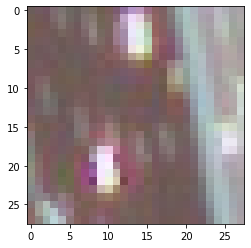

torch.Size([1, 3, 28, 28])
(1, 64, 3, 3)
flattened embedding
(1, 576)
The input point needs to be of the same dimension as
                  `input_dim` when initializing this LSHash instance shapes (1,576) and (1,576) not aligned: 576 (dim 1) != 1 (dim 0)


ValueError: shapes (1,576) and (1,576) not aligned: 576 (dim 1) != 1 (dim 0)

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder = ConvEncoder()

# Load the state dict of encoder
encoder.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
encoder.eval()
encoder.to(device)

# Loads the embedding
embedding = np.load(EMBEDDING_PATH)
test_img = Image.open(TEST_IMAGE_PATH).convert("RGB")
plt.imshow(test_img)
plt.show()
indices_list = compute_similar_images(TEST_IMAGE_PATH, NUM_IMAGES, embedding, device)
plot_similar_images(indices_list)

In [63]:

nbits = 128  # number of hyperplanes and binary vals to produce
d = 12  # vector dimensions

In [64]:
import numpy as np
# create a set of 4 hyperplanes, with 2 dimensions
plane_norms = np.random.rand(nbits, d) - .5
plane_norms

array([[-0.17663986, -0.47515665, -0.25475753, ..., -0.34984148,
         0.43382567,  0.25103632],
       [-0.2082735 ,  0.43248968, -0.03093244, ...,  0.10211122,
         0.46370967,  0.09459642],
       [-0.2090817 , -0.36018824,  0.09016499, ..., -0.39382654,
        -0.42365891, -0.37993116],
       ...,
       [-0.15645204,  0.46213432,  0.30721646, ...,  0.33493608,
         0.07621659,  0.07090659],
       [-0.24802427,  0.18376989, -0.10687889, ..., -0.31694203,
        -0.14463738,  0.38073999],
       [-0.04128877,  0.07768719, -0.05390441, ...,  0.00559373,
        -0.16155653,  0.39817165]])

In [52]:
a = np.asarray([1, 2])
b = np.asarray([2, 1])
c = np.asarray([3, 1])

In [53]:
a_dot = np.dot(a, plane_norms.T)
b_dot = np.dot(b, plane_norms.T)
c_dot = np.dot(c, plane_norms.T)
a_dot

array([-0.73417344, -0.50327018,  0.86757322,  0.69679384])

In [55]:
a_dot = a_dot.astype(int)
b_dot = b_dot.astype(int)
c_dot = c_dot.astype(int)
a_dot

array([0, 0, 1, 1])

In [56]:

vectors = [a_dot, b_dot, c_dot]
buckets = {}
i = 0

for i in range(len(vectors)):
    # convert from array to string
    hash_str = ''.join(vectors[i].astype(str))
    # create bucket if it doesn't exist
    if hash_str not in buckets.keys():
        buckets[hash_str] = []
    # add vector position to bucket
    buckets[hash_str].append(i)

print(buckets)

{'0011': [0], '1011': [1], '1010': [2]}


In [59]:
def load_tensor(image_path, device):
    image_tensor = T.ToTensor()(Image.open(image_path))
    image_tensor = image_tensor.unsqueeze(0)
    # print(image_tensor.shape)
    # input_images = image_tensor.to(device)
    return image_tensor

In [60]:
image_embedding_array = []
for images in image_files:
        image_tensor = load_tensor(images,device)
        with torch.no_grad():
                image_embedding = encoder(image_tensor).cpu().detach().numpy()
        flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
        image_embedding_array.append(flattened_embedding)

In [ ]:
def all_binary(n):
    total = 1 << n
    print(f"{total} possible combinations")
    combinations = []
    for i in range(total):
        # get binary representation of integer
        b = bin(i)[2:]
        # pad zeros to start of binary representtion
        b = '0' * (n - len(b)) + b
        b = [int(i) for i in b]
        combinations.append(b)
    return combinations

class RandomProjection:
    # initialize what will be the buckets
    buckets = {}
    # initialize counter
    counter = 0

    def __init__(self, nbits, d):
        self.nbits = nbits
        self.d = d
        # create our hyperplane normal vecs for splitting data
        self.plane_norms = np.random.rand(d, nbits) - .5
        print(f"Initialized {self.plane_norms.shape[1]} hyperplane normal vectors.")
        # add every possible combination to hashes attribute as numpy array
        self.hashes = all_binary(nbits)
        # and add each as a key to the buckets dictionary
        for hash_code in self.hashes:
            # convert to string
            hash_code = ''.join([str(i) for i in hash_code])
            self.buckets[hash_code] = []
        # convert self.hashes to numpy array
        self.hashes = np.stack(self.hashes)

    def get_binary(self, vec):
        # calculate nbits dot product values
        direction = np.dot(vec, self.plane_norms)
        # find positive direction (>0) and negative direction (<=0)
        direction = direction > 0
        # convert boolean array to integer strings
        binary_hash = direction.astype(int)
        return binary_hash
        
    def hash_vec(self, vec, show=False):
        # generate hash
        binary_hash = self.get_binary(vec)
        # convert to string format for dictionary
        binary_hash = ''.join(binary_hash.astype(str))
        # add ID to buckets dictionary
        self.buckets[binary_hash].append(self.counter)
        if show:
            print(f"{self.counter}: {''.join(binary_hash)}")
        # increment counter
        self.counter += 1
    
    def hamming(self, hashed_vec):
        # get hamming distance between query vec and all buckets in self.hashes
        hamming_dist = np.count_nonzero(hashed_vec != self.hashes, axis=1).reshape(-1, 1)
        # add hash values to each row
        hamming_dist = np.concatenate((self.hashes, hamming_dist), axis=1)
        # sort based on distance
        hamming_dist = hamming_dist[hamming_dist[:, -1].argsort()]
        return hamming_dist
    
    def top_k(self, vec, k=5):
        # generate hash
        binary_hash = self.get_binary(vec)
        # calculate hamming distance between all vectors
        hamming_dist = self.hamming(binary_hash)
        # loop through each bucket until we have k or more vector IDs
        vec_ids = []
        for row in hamming_dist:
            str_hash = ''.join(row[:-1].astype(str))
            bucket_ids = self.buckets[str_hash]
            vec_ids.extend(bucket_ids)
            if len(vec_ids) >= k:
                vec_ids = vec_ids[:k]
                break
        # return top k IDs
        return vec_ids

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

# 1M samples
wb = read_fvecs('../../../data/sift/sift_base.fvecs')
# queries
xq = read_fvecs('../../../data/sift/sift_query.fvecs')

In [204]:

def all_binary(n):
    total = 1 << n
    print(f"{total} possible combinations")
    combinations = []
    for i in range(total):
        # get binary representation of integer
        b = bin(i)[2:]
        # pad zeros to start of binary representtion
        b = '0' * (n - len(b)) + b
        b = [int(i) for i in b]
        combinations.append(b)
    return combinations

class RandomProjection:
    # initialize what will be the buckets
    buckets = {}
    # initialize counter
    counter = 0

    def __init__(self, nbits, d):
        self.nbits = nbits
        self.d = d
        # create our hyperplane normal vecs for splitting data
        np.random.seed(10)
        self.plane_norms = np.random.rand(d, nbits) - .5
        print(f"Initialized {projection.plane_norms.shape[1]} hyperplane normal vectors.")
        # add every possible combination to hashes attribute as numpy array
        self.hashes = all_binary(nbits)
        # and add each as a key to the buckets dictionary
        for hash_code in self.hashes:
            # convert to string
            hash_code = ''.join([str(i) for i in hash_code])
            self.buckets[hash_code] = []
        # convert self.hashes to numpy array
        self.hashes = np.stack(self.hashes)

    def get_binary(self, vec):
        # calculate nbits dot product values
        direction = np.dot(vec, projection.plane_norms)
        # find positive direction (>0) and negative direction (<=0)
        direction = direction > 0
        # convert boolean array to integer strings
        binary_hash = direction.astype(int)
        return binary_hash
        
    def hash_vec(self, vec, show=False):
        # generate hash
        binary_hash = self.get_binary(vec)
        # convert to string format for dictionary
        binary_hash = ''.join(binary_hash.astype(str))
        # add ID to buckets dictionary
        self.buckets[binary_hash].append(self.counter)
        if show:
            print(f"{self.counter}: {''.join(binary_hash)}")
        # increment counter
        self.counter += 1
    
    def hamming(self, hashed_vec):
        # get hamming distance between query vec and all buckets in self.hashes
        hamming_dist = np.count_nonzero(hashed_vec != projection.hashes, axis=1).reshape(-1, 1)
        # add hash values to each row
        hamming_dist = np.concatenate((projection.hashes, hamming_dist), axis=1)
        # sort based on distance
        hamming_dist = hamming_dist[hamming_dist[:, -1].argsort()]
        return hamming_dist
    
    def top_k(self, vec, k=5):
        # generate hash
        binary_hash = self.get_binary(vec)
        # calculate hamming distance between all vectors
        hamming_dist = self.hamming(binary_hash)
        # loop through each bucket until we have k or more vector IDs
        vec_ids = []
        for row in hamming_dist:
            str_hash = ''.join(row[:-1].astype(str))
            bucket_ids = self.buckets[str_hash]
            vec_ids.extend(bucket_ids)
            if len(vec_ids) >= k:
                vec_ids = vec_ids[:k]
                break
        # return top k IDs
        return vec_ids

In [134]:
image_embedding_array_new = []
# encoder.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
# encoder.eval()
# encoder.to(device)

# # Loads the embedding
# embedding = np.load(EMBEDDING_PATH)
for images in image_files:
        image_tensor = load_tensor(images,device)
        with torch.no_grad():
                image_embedding = encoder(image_tensor).cpu().detach().numpy()
        flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
        image_embedding_array_new.append(flattened_embedding[0])

In [144]:
image_embedding_array_new[0].shape[0]

576

In [205]:
projection = RandomProjection(6, image_embedding_array[1].shape[1])

Initialized 6 hyperplane normal vectors.
64 possible combinations


In [169]:
projection.plane_norms.shape

(576, 6)

In [210]:
projection.hash_vec(image_embedding_array[6666][0], show=True)

4: 001010


In [171]:
image_embedding_array[0].shape

(1, 576)

In [85]:
for i in range(1, len(image_embedding_array)-1):
    projection.hash_vec(image_embedding_array[i][0])

In [89]:
top_10 = projection.top_k(image_embedding_array[0][0], k=10)
top_10

[0, 1, 2, 3, 4, 6, 7, 9, 11, 12]

In [93]:
from sklearn.metrics.pairwise import cosine_similarity

In [102]:
similar_images = []
for i in top_10:
    similar_images.append(image_embedding_array[i][0])

In [107]:
all_images = []
for images in image_embedding_array:
    all_images.append(np.asarray(images[0]))

In [106]:
cos = cosine_similarity(np.asarray(similar_images), [image_embedding_array[0][0]])
np.mean(cos)

0.9732129

In [109]:
cos = cosine_similarity(all_images, [image_embedding_array[0][0]])
np.mean(cos)

0.9390613

In [116]:
import random
random_images = []
for i in range(10):
    random_image = random.choice(all_images)
    random_images.append(random_image)

In [121]:
def sim_check(query_vecs):
    results = {'xq': [], 'wb': []}
    for xq in query_vecs:
        top_10 = projection.top_k(xq, k=10)
        considered_images = []
        for i in top_10:
            considered_images.append(all_images[i])
        cos = cosine_similarity(considered_images, [xq])
        cos = np.mean(cos)
        results['xq'].append(cos)
        cos = cosine_similarity(all_images, [xq])
        cos = np.mean(cos)    
        results['wb'].append(cos)
    print(f"random images: {np.mean(results['xq'])}")
    print(f"all images: {np.mean(results['wb'])}")
    return results

In [122]:

results = sim_check(random_images)

random images: 0.8754922151565552
all images: 0.9331744909286499


In [124]:
import pandas as pd

In [127]:

testing = pd.DataFrame({
    'nbits': [],
    'random_images_sim': []
})

num_vecs = 10

for epoch in range(3):
    print('.')
    for nbits in [2, 4, 8, 12]:
        # initialize projection object
        projection = RandomProjection(nbits, np.asarray(all_images).shape[1])
        # add all our vectors
        for i in range(len(all_images)-1):
            projection.hash_vec(all_images[i])
        # get results from sim_check
        results = sim_check(random_images[:num_vecs])
        testing = testing.append(pd.DataFrame({
            'nbits': [nbits]*num_vecs,
            'random_images_sim': results['xq']
        }), ignore_index=True)

.
Initialized 2 hyperplane normal vectors.
4 possible combinations
random images: 0.8812974095344543
all images: 0.9331744909286499
Initialized 4 hyperplane normal vectors.
16 possible combinations
random images: 0.8888794183731079
all images: 0.9331744909286499
Initialized 8 hyperplane normal vectors.
256 possible combinations
random images: 0.8812181353569031
all images: 0.9331744909286499
Initialized 12 hyperplane normal vectors.
4096 possible combinations
random images: 0.9493486285209656
all images: 0.9331744909286499
.
Initialized 2 hyperplane normal vectors.
4 possible combinations
random images: 0.8812974095344543
all images: 0.9331744909286499
Initialized 4 hyperplane normal vectors.
16 possible combinations
random images: 0.8761838674545288
all images: 0.9331744909286499
Initialized 8 hyperplane normal vectors.
256 possible combinations
random images: 0.8937332034111023
all images: 0.9331744909286499
Initialized 12 hyperplane normal vectors.
4096 possible combinations
random 